Run the cell below if you are using Google Colab to mount your Google Drive in your Colab instance. Adjust the path to the files in your Google Drive as needed if it differs.

If you do not use Google Colab, running the cell will simply do nothing, so do not worry about it.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd 'drive/My Drive/Colab Notebooks/05_Classification'
except ImportError as e:
    pass

## Exercise 5: Classification

### 5.1. Parameter optimization
In Exercise 4.2 we have used the German credit data set from the UCI data set library (http://archive.ics.uci.edu/ml/index.html), which describes the customers of a bank with respect to whether they should get a bank credit or not. The data set is provided as credit-g.arff file in ILIAS.

#### 5.1.1.	(recap) Go back to the results of exercise 4.2.4. Re-run the classifiers with their default parameter settings.
- Used the 10-fold validation approach.
- Balanced the training set multiplying the “bad customer” examples. 
- Evaluated the results, setting up your cost matrix to ((0,100)(1,0)) – that is, you assumed you will lose 1 Unit if you refuse a credit to a good customer, but that you lose 100 Units if you give a bad customer a credit.

Rerun your process to get the performance results. What were the default parameters of the Decision Tree?

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

First, we load the dataset:

In [3]:
import pandas as pd
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder

credit_arff_data, credit_arff_meta = arff.loadarff(open('credit-g.arff', 'r'))
credit_data = pd.DataFrame(credit_arff_data)

# select all columns of type object
columns_with_binary_strings = credit_data.select_dtypes('object').columns.values

# decode the values of these columns using utf-8
credit_data[columns_with_binary_strings] = credit_data[columns_with_binary_strings].apply(lambda x: x.str.decode("utf-8"))
credit_target = credit_data['class']
credit_data = credit_data.drop(columns='class')

label = LabelEncoder()
credit_target = label.fit_transform(credit_target)
label_names=['bad','good']
label_order=label.transform(label_names)

credit_data.head()

checking_status  duration                  credit_history  \
0              <0       6.0  critical/other existing credit   
1        0<=X<200      48.0                   existing paid   
2     no checking      12.0  critical/other existing credit   
3              <0      42.0                   existing paid   
4              <0      24.0              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv         1169.0  no known savings        >=7   
1             radio/tv         5951.0              <100     1<=X<4   
2            education         2096.0              <100     4<=X<7   
3  furniture/equipment         7882.0              <100     4<=X<7   
4              new car         4870.0              <100     1<=X<4   

   installment_commitment     personal_status other_parties  residence_since  \
0                     4.0         male single          none              4.0   
1                     2.0  female div/dep/mar          none              2.0   
2                     2.0         male single          none              3.0   
3                     2.0         male single     guarantor              4.0   
4                     3.0         male single          none              4.0   

  property_magnitude   age other_payment_plans   housing  existing_credits  \
0        real estate  67.0                none       own               2.0   
1        real estate  22.0                none       own               1.0   
2        real estate  49.0                none       own               1.0   
3     life insurance  45.0                none  for free               1.0   
4  no known property  53.0                none  for free               2.0   

                  job  num_dependents own_telephone foreign_worker  
0             skilled             1.0           yes            yes  
1             skilled             1.0          none            yes  
2  unskilled resident             2.0          none            yes  
3             skilled             2.0          none            yes  
4             skilled             2.0          none            yes

Then, we set up a pipeline and evaluate it using cross validation:

Decision Tree with accuracy of 0.675 and cost 16957


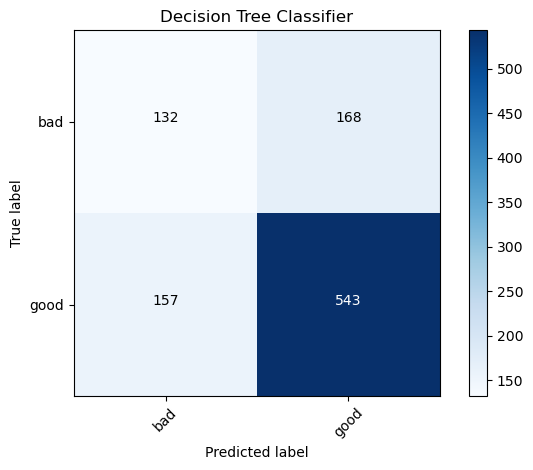

              precision    recall  f1-score   support

         bad       0.46      0.44      0.45       300
        good       0.76      0.78      0.77       700

    accuracy                           0.68      1000
   macro avg       0.61      0.61      0.61      1000
weighted avg       0.67      0.68      0.67      1000



In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

numeric_features = ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
categorical_features = ['credit_history', 'purpose', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
ordinal_features = [ 'checking_status', 'savings_status', 'employment']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('ord', OrdinalEncoder(categories=[
            [ 'no checking', '<0', '0<=X<200', '>=200' ],
            [ 'no known savings', '<100', '100<=X<500', '500<=X<1000', '>=1000' ],
            [ 'unemployed', '<1', '1<=X<4', '4<=X<7', '>=7' ]
        ]), ordinal_features)])

pipeline = Pipeline([ 
    ('preprocessing', preprocessor), 
    ('balancing', RandomOverSampler()),
    ('estimator', DecisionTreeClassifier()) ])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

prediction = cross_val_predict(pipeline, credit_data, credit_target, cv=cv)

def cost_function(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred, labels=label_order)
    return cm[0][1] * 100 + cm[1][0] * 1

cm = confusion_matrix(credit_target, prediction, labels=label_order)
cost = cost_function(credit_target, prediction)
acc = accuracy_score(credit_target, prediction)

print("Decision Tree with accuracy of {} and cost {}".format(acc, cost))
plot_confusion_matrix(cm, classes=label_names, title='Decision Tree Classifier')
plt.show()
print(classification_report(credit_target, prediction, target_names=label_names))

Finally, we fit the pipeline to the dataset and plot the decision tree:

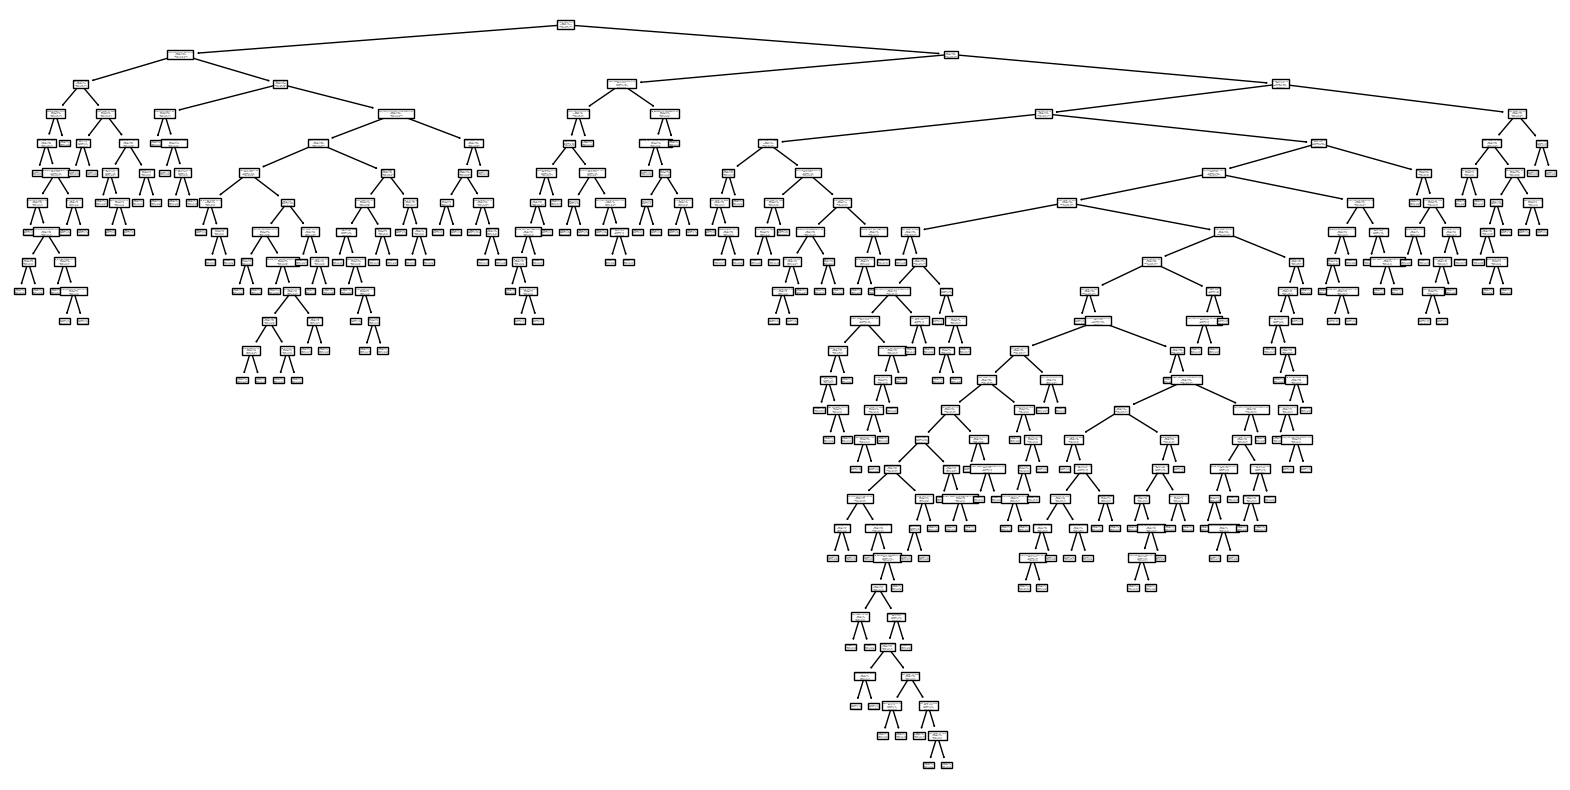

In [5]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.utils.multiclass import unique_labels

pipeline.fit(credit_data, credit_target)

estimator = pipeline.named_steps['estimator']
pre = pipeline.named_steps['preprocessing']
feature_names = numeric_features + list(pre.named_transformers_['cat'].get_feature_names_out(categorical_features)) + ordinal_features

plt.figure(figsize=(20,10))
tree.plot_tree(estimator,
               feature_names=feature_names,
                class_names=label_names)
plt.show()

Default Parameters for decision tree:

In [6]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

#### 5.1.2.	Now try to find a more optimal configuration for the Decision Tree. What is the best parameter setting and what is the cross-validated performance of this appraoch?

Use the GridSearchCV from scikit learn. Try the following parameters of the Decision Tree:
- criterion: ['gini', 'entropy']
- 'max_depth': [2, 3, 4, 5, None]
- 'min_samples_split' :[2,3,4,5]

What is the best configuration for the data set and the classification approach? 

Note: The grid search can take some time. You can use the ```n_jobs=-1``` parameter setting for the ```cross_val_predict()``` function to enable parallel processing (all CPU cores will be used).

Optimised Decision Tree with accuracy of 0.614 and cost 6623


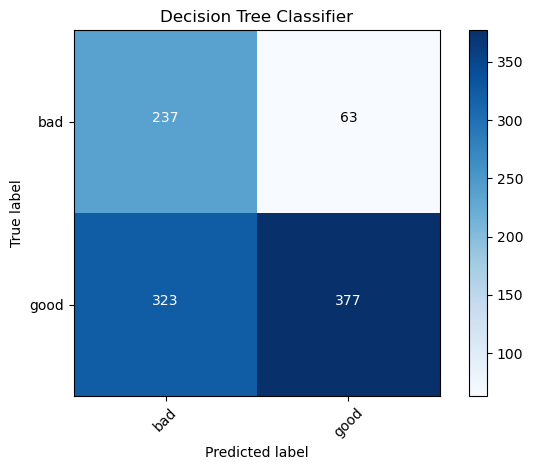

              precision    recall  f1-score   support

         bad       0.42      0.79      0.55       300
        good       0.86      0.54      0.66       700

    accuracy                           0.61      1000
   macro avg       0.64      0.66      0.61      1000
weighted avg       0.73      0.61      0.63      1000

Optimised Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 2, 'estimator__min_samples_split': 5}


In [7]:
from sklearn.model_selection import GridSearchCV

# define the parameter grid
parameters = {
    'estimator__criterion':['gini', 'entropy'], 
    'estimator__max_depth':[ 2, 3, 4, 5, None],
    'estimator__min_samples_split' :[2,3,4,5]
}

# define the folds for the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create a scorer for the grid search
cost_score = make_scorer(cost_function, greater_is_better=False)

# create the grid search estimator
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=cost_score, cv=stratified_10_fold_cv)

# cross-validate
prediction = cross_val_predict(grid_search_estimator, credit_data, credit_target, cv=cv, n_jobs=-1)

# calculate costs
cm = confusion_matrix(credit_target, prediction, labels=label_order)
cost = cost_function(credit_target, prediction)
acc = accuracy_score(credit_target, prediction)

print("Optimised Decision Tree with accuracy of {} and cost {}".format(acc, cost))
plot_confusion_matrix(cm, classes=label_names, title='Decision Tree Classifier')
plt.show()
print(classification_report(credit_target, prediction, target_names=label_names))

# fit the grid search (= determine the optimal parameters)
grid_search_estimator.fit(credit_data, credit_target)
print("Optimised Parameters: {}".format(grid_search_estimator.best_params_))

#### 5.1.4.	How does the optimal decision tree differ from the one you have learned in 4.2.4?
Plot the optimised tree!

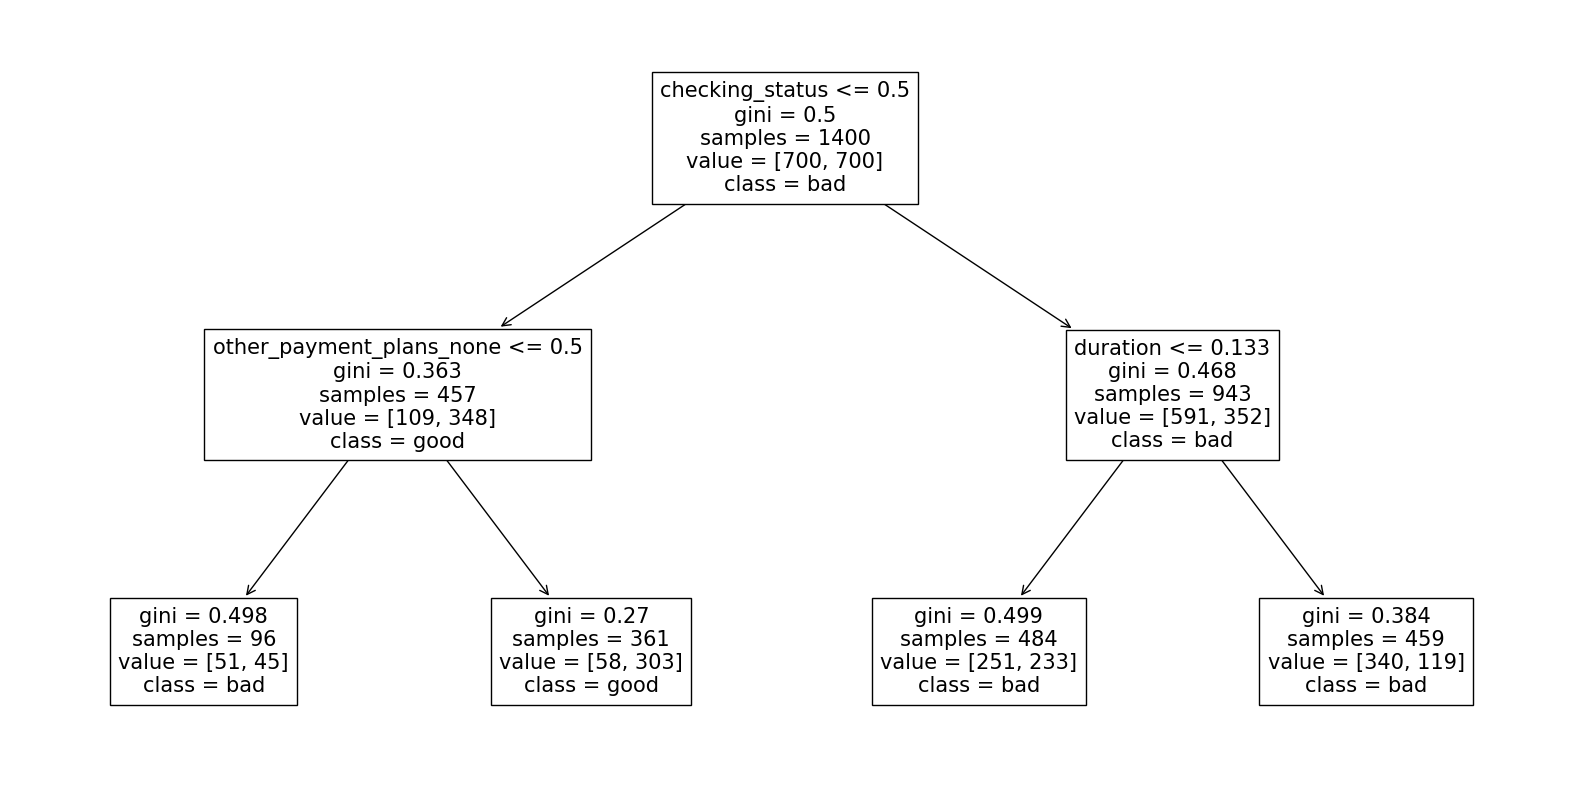

In [8]:
estimator = grid_search_estimator.best_estimator_.named_steps['estimator']
pre = grid_search_estimator.best_estimator_.named_steps['preprocessing']
feature_names = numeric_features + list(pre.named_transformers_['cat'].get_feature_names_out(categorical_features)) + ordinal_features

plt.figure(figsize=(20,10))
tree.plot_tree(estimator,
               feature_names=feature_names,
                class_names=label_names)
plt.show()

### 5.2. Open Competition: Finding rich Americans
The Adult data set from the UCI data set library (http://archive.ics.uci.edu/ml/datasets/Adult) describes 48842 persons from the 1994 US Census. The data set is provided as adult.arff file on the website of this course. 

Your task is to find a good classifier for determining whether a person earns over 50.000 $ 
a year. Beside of being accurate, your classifier should also have balanced precision and recall.

To evaluate your classifiers use train_test_split validation (test_size=0.2, random_state=42).
In order to find the best classifier, you may experiment with:
1.	different algorithms
2.	different parameter settings
3.	the balance of the two classes in the data set
4.	the set of attributes that are used or not used
5.	other preprocessing techniques

In order to increase your understanding of the data set, you might want to visualize different attributes or attribute combinations.

In [9]:
adult_arff_data, adult_arff_meta = arff.loadarff(open('adult.arff', 'r'))
adult = pd.DataFrame(adult_arff_data)
adult = adult.applymap(lambda x: x.decode('utf8').replace("'", "") if hasattr(x, 'decode') else x)

adult_target = np.array(adult['class'])
adult_data = adult.drop('class', axis=1)
adult_data.head()

age  workclass    fnlwgt     education  education-num      marital-status  \
0  25.0    Private  226802.0          11th            7.0       Never-married   
1  38.0    Private   89814.0       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov  336951.0    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  160323.0  Some-college           10.0  Married-civ-spouse   
4  18.0          ?  103497.0  Some-college           10.0       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male           0.0           0.0   
1    Farming-fishing      Husband  White    Male           0.0           0.0   
2    Protective-serv      Husband  White    Male           0.0           0.0   
3  Machine-op-inspct      Husband  Black    Male        7688.0           0.0   
4                  ?    Own-child  White  Female           0.0           0.0   

   hours-per-week native-country  
0            40.0  United-States  
1            50.0  United-States  
2            40.0  United-States  
3            40.0  United-States  
4            30.0  United-States

In [10]:
# Create train/test split
from sklearn.model_selection import train_test_split
adult_data_train, adult_data_test, adult_target_train, adult_target_test = train_test_split(
    adult_data, adult_target, test_size=0.2, random_state=42)

First, define a ColumnTransformer to handle the preprocessing:

In [11]:
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
numeric_transformer = Pipeline([ ('scaler', StandardScaler()) ])

categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
categorical_transformer = Pipeline([ ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore')) ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', DecisionTreeClassifier()) ])

Then, test a couple of classification methods as baseline:

DecisionTreeClassifier
              precision    recall  f1-score   support

       <=50K       0.88      0.87      0.88     29676
        >50K       0.61      0.62      0.61      9397

    accuracy                           0.81     39073
   macro avg       0.74      0.75      0.74     39073
weighted avg       0.81      0.81      0.81     39073

KNeighborsClassifier
              precision    recall  f1-score   support

       <=50K       0.88      0.91      0.89     29676
        >50K       0.68      0.60      0.64      9397

    accuracy                           0.83     39073
   macro avg       0.78      0.75      0.76     39073
weighted avg       0.83      0.83      0.83     39073

GaussianNB
              precision    recall  f1-score   support

       <=50K       0.96      0.52      0.67     29676
        >50K       0.38      0.93      0.54      9397

    accuracy                           0.62     39073
   macro avg       0.67      0.72      0.61     39073
weighted avg       

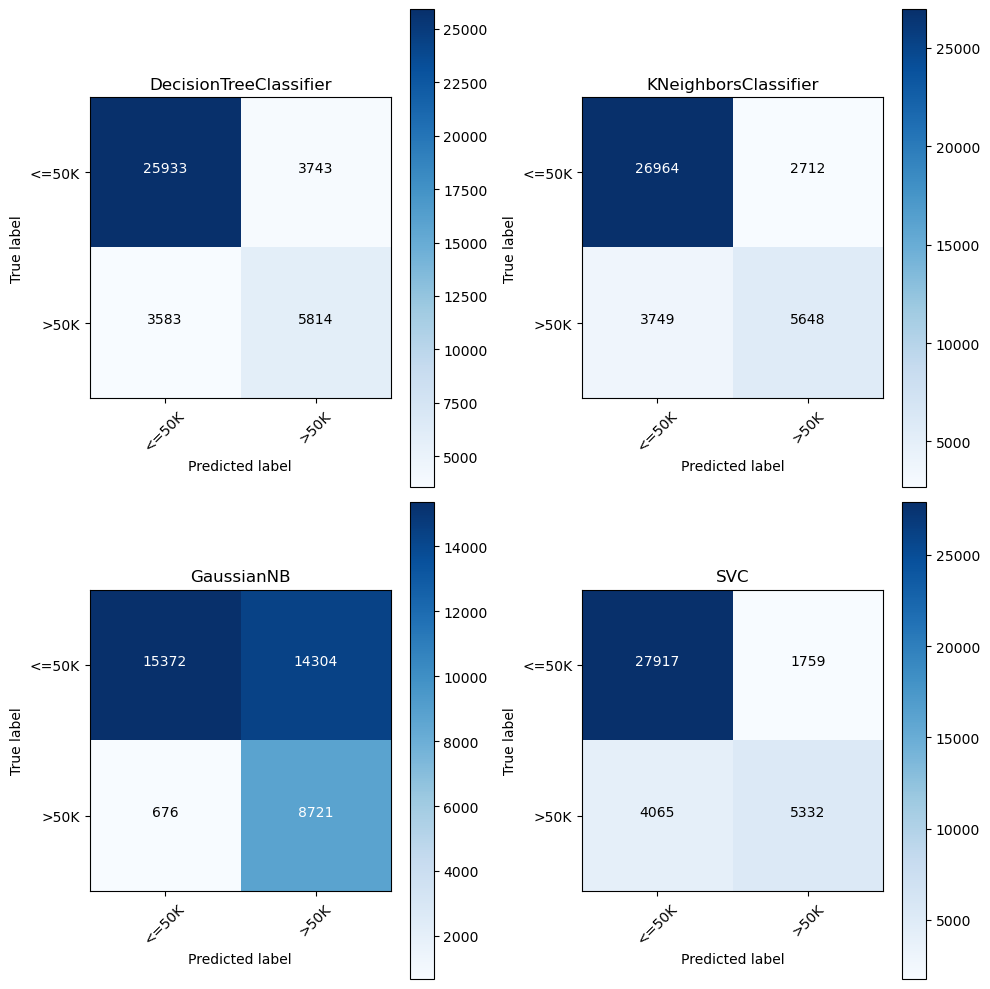

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

estimators = [
    DecisionTreeClassifier(), KNeighborsClassifier(), GaussianNB(), SVC(gamma='auto')
]

plt.figure(figsize=(10,10))

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for i, estimator in enumerate(estimators):
    plt.subplot(2,2,i+1)
    pipeline.set_params(estimator=estimator)
    prediction = cross_val_predict(pipeline, adult_data_train, adult_target_train, cv=cv, n_jobs=-1)
    cm = confusion_matrix(adult_target_train, prediction)
    plot_confusion_matrix(cm, classes=unique_labels(adult_target_train), title=type(estimator).__name__)
    print(type(estimator).__name__)
    print(classification_report(adult_target_train, prediction))
    
plt.show()

Have a look at the class distribution:

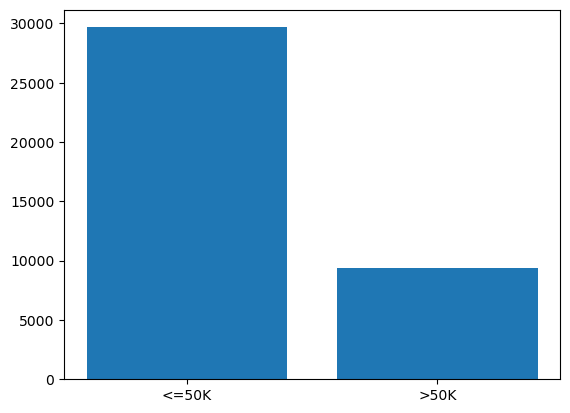

In [13]:
class_dist = pd.Series(adult_target_train).value_counts()
plt.bar(class_dist.index, class_dist)
plt.show()

The classes are imbalanced, so we try balancing and a grid search over the hyper-parameters to try and improve our classifiers.
We also define a score (F1-measure) to use for the grid search, as accuracy can be misleading for imbalanced datasets.

In [14]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, make_scorer

pipeline = Pipeline([ ('preprocessing', preprocessor), ('balancing', RandomUnderSampler()), ('estimator', DecisionTreeClassifier()) ])

# define the scoring function
f1 = make_scorer(f1_score, pos_label='>50K')

# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1)

Optimise parameters for decision tree:

In [15]:
pipeline.set_params(estimator=DecisionTreeClassifier())

grid_search_estimator.param_grid = {
    'estimator__max_depth': [ 2, 3, 4]
}

grid_search_estimator.fit(adult_data_train, adult_target_train)

print("Decision Tree: {}% F1-score for class '>50K' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

C:\Users\alebrink\anaconda3\envs\dm1_fss2023\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Decision Tree: 63.572796558434185% F1-score for class '>50K' with parameters {'estimator__max_depth': 4}


Optimise parameters for K-NN:

In [16]:
pipeline.set_params(estimator=KNeighborsClassifier())

grid_search_estimator.param_grid = {
    'estimator__n_neighbors': [ 2, 3, 4]
}

grid_search_estimator.fit(adult_data_train, adult_target_train)

print("K-NN: {}% F1-score for class '>50K' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

C:\Users\alebrink\anaconda3\envs\dm1_fss2023\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


K-NN: 64.02986338428487% F1-score for class '>50K' with parameters {'estimator__n_neighbors': 4}


Select the best model based on cross validated scores on the training set, then evaluate it on the test set:

C:\Users\alebrink\anaconda3\envs\dm1_fss2023\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

       <=50K       0.91      0.83      0.87      7479
        >50K       0.58      0.75      0.65      2290

    accuracy                           0.81      9769
   macro avg       0.75      0.79      0.76      9769
weighted avg       0.84      0.81      0.82      9769



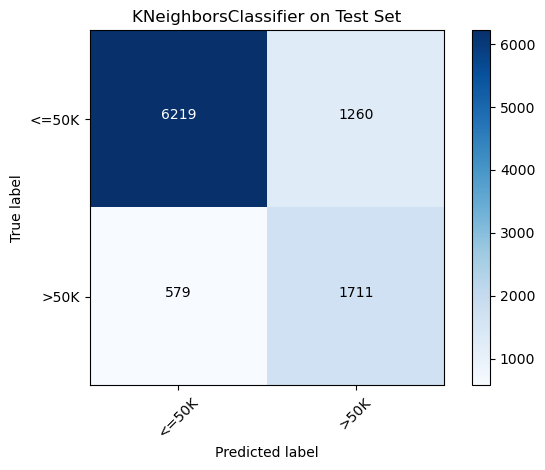

In [17]:
# configure the pipeline to use the best estimator and hyper-parameters based on the training set
pipeline.set_params(estimator=KNeighborsClassifier())
pipeline.set_params(estimator__n_neighbors=4)
pipeline.fit(adult_data_train, adult_target_train)

# evaluate the pipeline on the test set to get an estimate of the accuracy on unseen data
prediction = pipeline.predict(adult_data_test)
cm = confusion_matrix(adult_target_test, prediction)
plot_confusion_matrix(cm, classes=unique_labels(adult_target_test), title="KNeighborsClassifier on Test Set")
print(classification_report(adult_target_test, prediction))